In [1]:
#%matplotlib notebook
%matplotlib inline

import numpy as np
#np.set_printoptions(threshold=np.nan)

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
from matplotlib import pyplot as plt
from matplotlib import cm

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

In [2]:
#ctapipe.version.get_version()
print(ctapipe.__version__)
print(pyhessio.__version__)

from ctapipe.instrument import CameraGeometry

0.5.1
2.0.1


In [3]:
# calibrator
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(None, None)

In [4]:
MAX_NUM_SAMPLES = 1000000

## Thresholds

In [5]:
astri_channel_threshold = 14   # FYI Tino uses 14
astri_konrad_channel_threshold = 14
lstcam_prod3_channel_threshold = 100
nectarcam_prod3_channel_threshold = 190

## Common functions

In [18]:
def scatter_plot(pee_array,                  # pixel energy estimate samples -> pe or adcsum
                 calibrated_in_ch0_array,
                 calibrated_in_ch1_array,
                 channel_threshold,
                 scatter_lim=None):
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13, 13))

    ax.scatter(pee_array,
               calibrated_in_ch0_array,
               s=0.5,         # radius
               c="black",     # color
               alpha=0.75,
               label="channel 0")

    ax.scatter(pee_array,
               calibrated_in_ch1_array,
               s=0.5,         # radius
               c="red",     # color
               alpha=0.75,
               label="channel 1")

    ax.axhline(channel_threshold)

    ax.set_xlabel("Pixel energy estimation (PE or ADC sum)", fontsize=16)
    ax.set_ylabel("Calibrated IN", fontsize=16)
    
    if scatter_lim is not None:
        ax.set_xlim(scatter_lim[0], scatter_lim[1])
        ax.set_ylim(scatter_lim[2], scatter_lim[3])
    
    plt.plot()

In [27]:
def histogram(pe_array,
              calibrated_in_ch0_array,
              calibrated_in_ch1_array,
              channel_threshold):
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13, 13))

    bin_max = channel_threshold + math.ceil(channel_threshold/2.)
    num_bins = min(bin_max, 30)

    if pe_array is not None:
        ax.hist(pe_array,
                alpha=0.5,
                log=True,
                bins=num_bins,
                range=(0, bin_max),
                label="PE")

    ax.hist(calibrated_in_ch0_array,
            alpha=0.5,
            log=True,
            bins=num_bins,
            range=(0, bin_max),
            label="Channel 0")

    ax.hist(calibrated_in_ch1_array,
            alpha=0.5,
            log=True,
            bins=num_bins,
            range=(0, bin_max),
            label="Channel 1")

    ax.axvline(channel_threshold)

    ax.set_xlabel("PE", fontsize=16)
    ax.set_ylabel("Count", fontsize=16)

    ax.legend(prop={'size': 18}, loc='best', fancybox=True, framealpha=0.5)
    
    plt.plot()

In [20]:
def plot_all(simtel_file_path,
             tel_id_filter_list,
             channel_threshold,
             scatter_lim=None,
             max_num_samples=MAX_NUM_SAMPLES):
    
    print("Tel ID range:", tel_id_filter_list)

    source = hessio_event_source(simtel_file_path,
                                 allowed_tels=tel_id_filter_list)

    # ITERATE OVER EVENTS #############################################

    pe_list = []
    adc_sum_list = []
    calibrated_in_ch0_list = []
    calibrated_in_ch1_list = []

    for ev in source:
        
        if (len(pe_list)) > 0 and (len(pe_list) * len(pe_list[0]) >= max_num_samples):
            break
            
        calib.calibrate(ev)  # calibrate the event

        #print(ev)

        # ITERATE OVER IMAGES #########################################

        for tel_id in ev.trig.tels_with_trigger:
            
            if (len(pe_list)) > 0 and (len(pe_list) * len(pe_list[0]) >= max_num_samples):
                break

            tel_id = int(tel_id)

            if tel_id in tel_id_filter_list:

                pe = ev.mc.tel[tel_id].photo_electron_image
                #pedestal = ev.mc.tel[tel_id].pedestal[channel]
                #gain = ev.mc.tel[tel_id].dc_to_pe[channel]
                uncalibrated_image = ev.r0.tel[tel_id].adc_sums[1]   # TODO...
                calibrated_image = ev.dl1.tel[tel_id].image

                pe_list.append(pe)
                adc_sum_list.append(uncalibrated_image)
                calibrated_in_ch0_list.append(calibrated_image[0])
                calibrated_in_ch1_list.append(calibrated_image[1])
    
    # Check the instrument ID
    for tel_id_check in tel_id_filter_list:
        x, y = ev.inst.pixel_pos[tel_id_check]
        foclen = ev.inst.optical_foclen[tel_id_check]
        geom = ctapipe.instrument.camera.CameraGeometry.guess(x, y, foclen)
        print("Tel {}: {} ({})".format(tel_id_check, geom.cam_id, geom.pix_type))

    pe_array = np.array(pe_list).ravel()
    adc_sum_array = np.array(adc_sum_list).ravel()
    calibrated_in_ch0_array = np.array(calibrated_in_ch0_list).ravel()
    calibrated_in_ch1_array = np.array(calibrated_in_ch1_list).ravel()

    print("ch0 max:", calibrated_in_ch0_array.max())
    print("num samples:", len(pe_array))
    
    # Plot
    
    if pe_array.max() == 0:
        # Prod3b South (no PE)
        scatter_plot(adc_sum_array,
                     calibrated_in_ch0_array,
                     calibrated_in_ch1_array,
                     channel_threshold,
                     scatter_lim)
        histogram(None,
                  calibrated_in_ch0_array,
                  calibrated_in_ch1_array,
                  channel_threshold)
    else:
        # Prod3b North
        scatter_plot(pe_array,
                     calibrated_in_ch0_array,
                     calibrated_in_ch1_array,
                     channel_threshold,
                     scatter_lim)
        histogram(pe_array,
                  calibrated_in_ch0_array,
                  calibrated_in_ch1_array,
                  channel_threshold)

## ASTRI mini array

In [9]:
#%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/astri_mini_array/simtel/gamma/run1001.simtel.gz

### ASTRI

ASTRI = "ASTRICam" (tel 1 to 33 in astri mini array), 2 channels

Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Tel 1: ASTRICam (rectangular)
Tel 2: ASTRICam (rectangular)
Tel 3: ASTRICam (rectangular)
Tel 4: ASTRICam (rectangular)
Tel 5: ASTRICam (rectangular)
Tel 6: ASTRICam (rectangular)
Tel 7: ASTRICam (rectangular)
Tel 8: ASTRICam (rectangular)
Tel 9: ASTRICam (rectangular)
Tel 10: ASTRICam (rectangular)
Tel 11: ASTRICam (rectangular)
Tel 12: ASTRICam (rectangular)
Tel 13: ASTRICam (rectangular)
Tel 14: ASTRICam (rectangular)
Tel 15: ASTRICam (rectangular)
Tel 16: ASTRICam (rectangular)
Tel 17: ASTRICam (rectangular)
Tel 18: ASTRICam (rectangular)
Tel 19: ASTRICam (rectangular)
Tel 20: ASTRICam (rectangular)
Tel 21: ASTRICam (rectangular)
Tel 22: ASTRICam (rectangular)
Tel 23: ASTRICam (rectangular)
Tel 24: ASTRICam (rectangular)
Tel 25: ASTRICam (rectangular)
Tel 26: ASTRICam (rectangular)
Tel 27: ASTRICam (rectangular)
Tel 28: ASTRICam (rectangular)
Tel

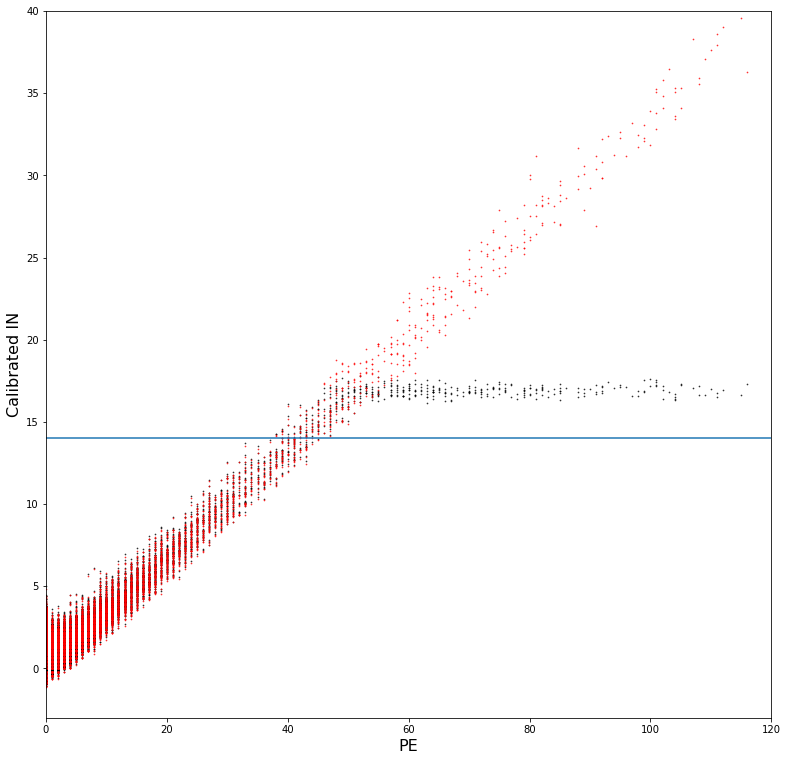

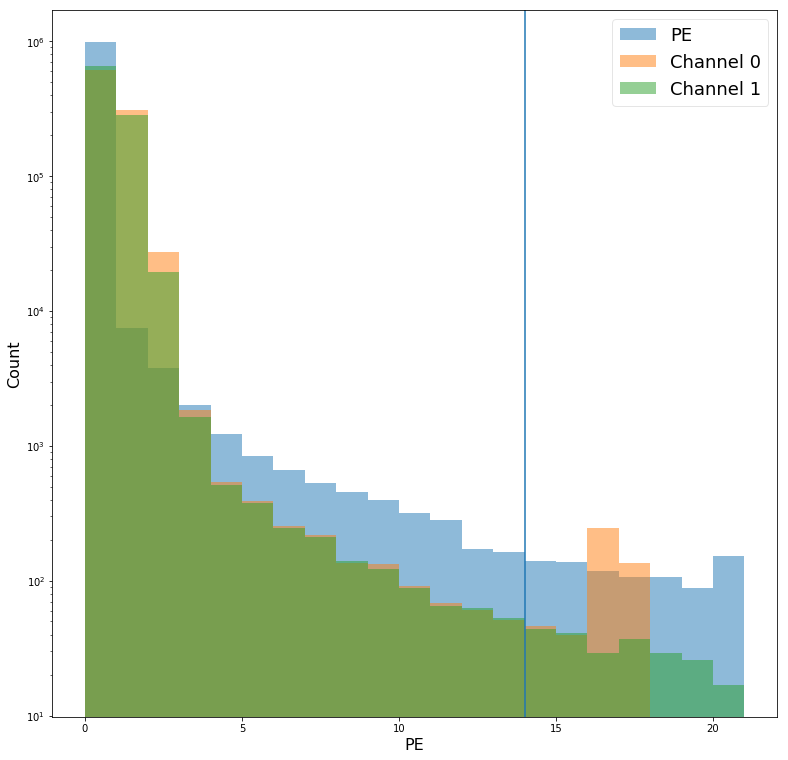

In [10]:
plot_all("/Users/jdecock/data/astri_mini_array/simtel/gamma/run1001.simtel.gz",
     tel_id_filter_list=list(range(1, 34)),
     channel_threshold=astri_channel_threshold,
     scatter_lim=(0, 120, -3, 40))

## Konrad's ASTRI mini array

In [11]:
#%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz

### ASTRI

ASTRI = "ASTRICam" (tel 1 to 16 in astri mini array), 2 channels

Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Tel 1: ASTRICam (rectangular)
Tel 2: ASTRICam (rectangular)
Tel 3: ASTRICam (rectangular)
Tel 4: ASTRICam (rectangular)
Tel 5: ASTRICam (rectangular)
Tel 6: ASTRICam (rectangular)
Tel 7: ASTRICam (rectangular)
Tel 8: ASTRICam (rectangular)
Tel 9: ASTRICam (rectangular)
Tel 10: ASTRICam (rectangular)
Tel 11: ASTRICam (rectangular)
Tel 12: ASTRICam (rectangular)
Tel 13: ASTRICam (rectangular)
Tel 14: ASTRICam (rectangular)
Tel 15: ASTRICam (rectangular)
Tel 16: ASTRICam (rectangular)
ch0 max: 17.9993698191
num samples: 1001664


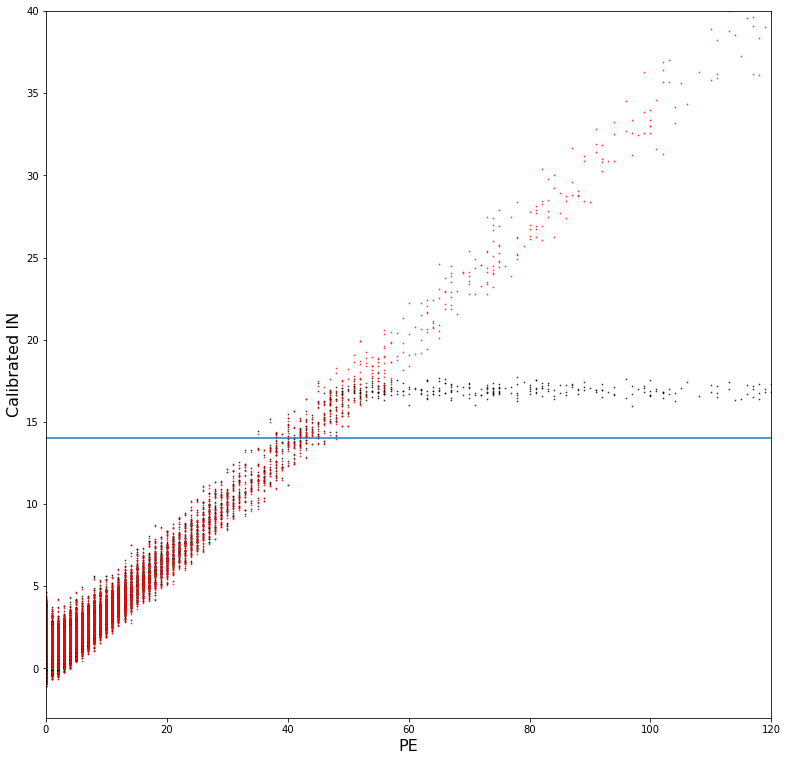

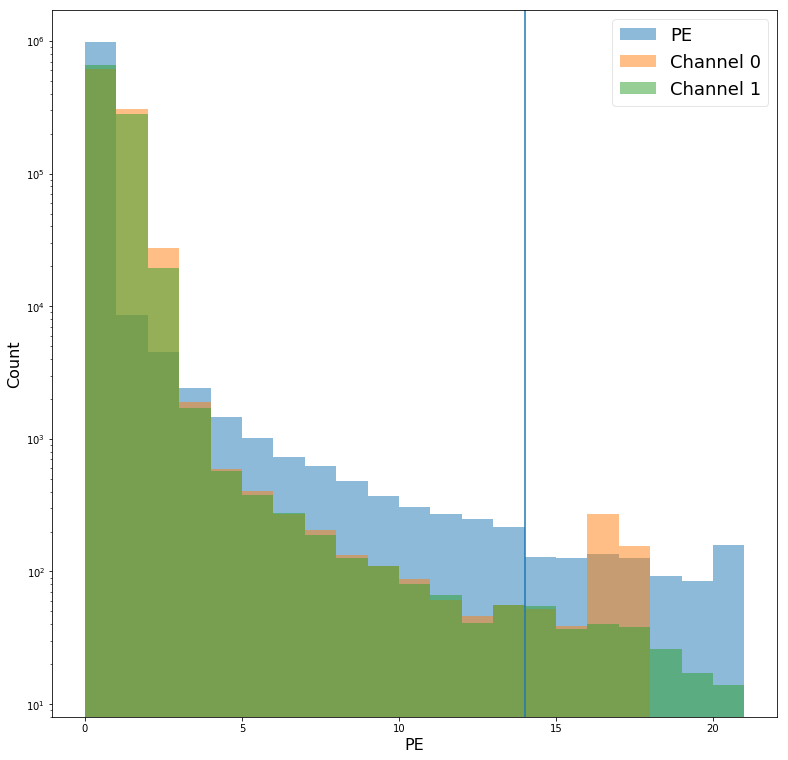

In [12]:
plot_all("/Users/jdecock/data/astri_mini_array_konrad/simtel/astri_v2/gamma/gamma_20deg_180deg_run2203___cta-prod3-sst-astri_desert-2150m-Paranal-sst-astri2.simtel.gz",
     tel_id_filter_list=list(range(1, 17)),
     channel_threshold=astri_konrad_channel_threshold,
     scatter_lim=(0, 120, -3, 40))

## Grid Prod3b - North site (LaPalma)

In [12]:
grid_prod3b_north_gamma_file_path = "/Users/jdecock/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run104___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
grid_prod3b_north_proton_file_path = "/Users/jdecock/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"

In [2]:
%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/grid_prod3b_north/simtel/gamma/gamma_20deg_0deg_run104___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz

Telescope 001: LSTCam (hexagonal pixels)
Telescope 002: LSTCam (hexagonal pixels)
Telescope 003: LSTCam (hexagonal pixels)
Telescope 004: LSTCam (hexagonal pixels)
Telescope 005: LSTCam (hexagonal pixels)
Telescope 006: LSTCam (hexagonal pixels)
Telescope 007: LSTCam (hexagonal pixels)
Telescope 008: LSTCam (hexagonal pixels)
Telescope 009: FlashCam (hexagonal pixels)
Telescope 010: FlashCam (hexagonal pixels)
Telescope 011: FlashCam (hexagonal pixels)
Telescope 012: FlashCam (hexagonal pixels)
Telescope 013: FlashCam (hexagonal pixels)
Telescope 014: FlashCam (hexagonal pixels)
Telescope 015: FlashCam (hexagonal pixels)
Telescope 016: FlashCam (hexagonal pixels)
Telescope 017: FlashCam (hexagonal pixels)
Telescope 018: FlashCam (hexagonal pixels)
Telescope 019: FlashCam (hexagonal pixels)
Telescope 020: FlashCam (hexagonal pixels)
Telescope 021: FlashCam (hexagonal pixels)
Telescope 022: FlashCam (hexagonal pixels)
Telescope 023: FlashCam (hexagonal pixels)
Telescope 024: FlashCam (he

In [15]:
#%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/grid_prod3b_north/simtel/proton/proton_20deg_0deg_run50001___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz

### LSTCam

Dragoncam = "LSTCam" (tel 1 to 8 in prod3b - North site (LaPalma)), 2 channels

Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8]
Tel 1: LSTCam (hexagonal)
Tel 2: LSTCam (hexagonal)
Tel 3: LSTCam (hexagonal)
Tel 4: LSTCam (hexagonal)
Tel 5: LSTCam (hexagonal)
Tel 6: LSTCam (hexagonal)
Tel 7: LSTCam (hexagonal)
Tel 8: LSTCam (hexagonal)
ch0 max: 206.88807621
num samples: 1001700


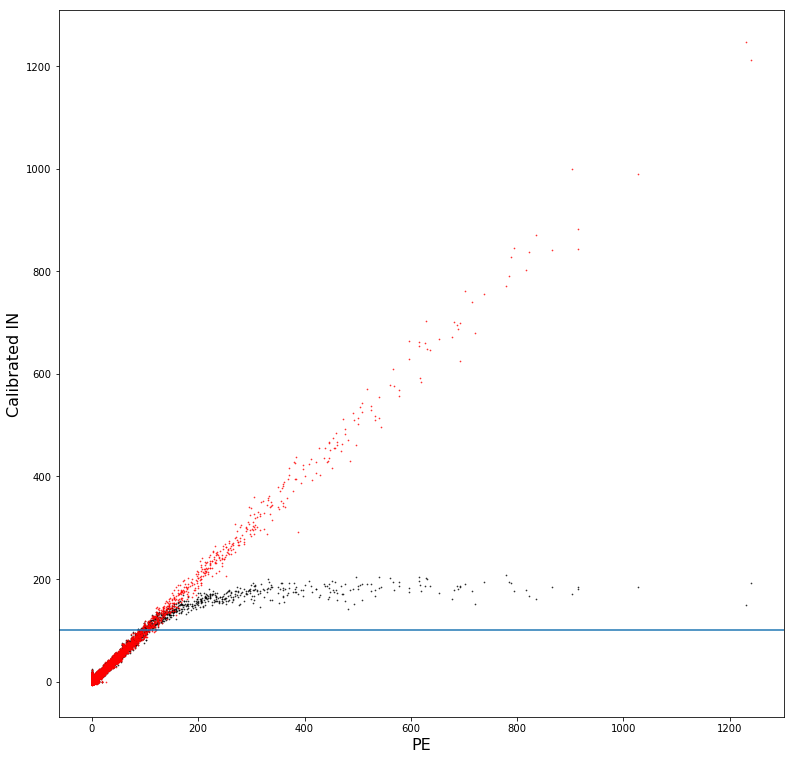

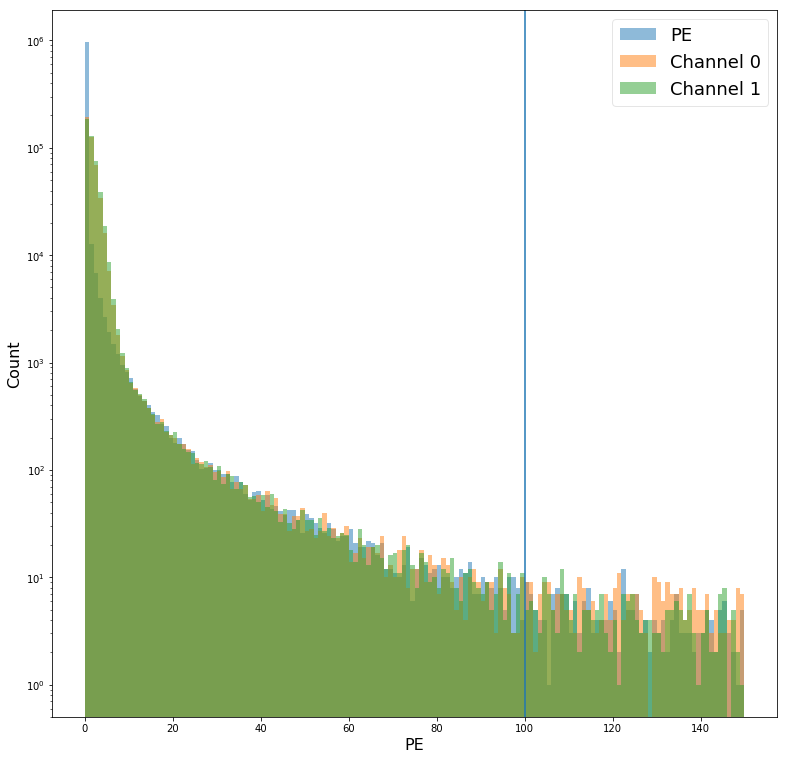

In [16]:
plot_all(grid_prod3b_north_gamma_file_path,
         tel_id_filter_list=list(range(1, 9)),
         channel_threshold=lstcam_prod3_channel_threshold)

Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8]
Tel 1: LSTCam (hexagonal)
Tel 2: LSTCam (hexagonal)
Tel 3: LSTCam (hexagonal)
Tel 4: LSTCam (hexagonal)
Tel 5: LSTCam (hexagonal)
Tel 6: LSTCam (hexagonal)
Tel 7: LSTCam (hexagonal)
Tel 8: LSTCam (hexagonal)
ch0 max: 194.167169685
num samples: 1001700


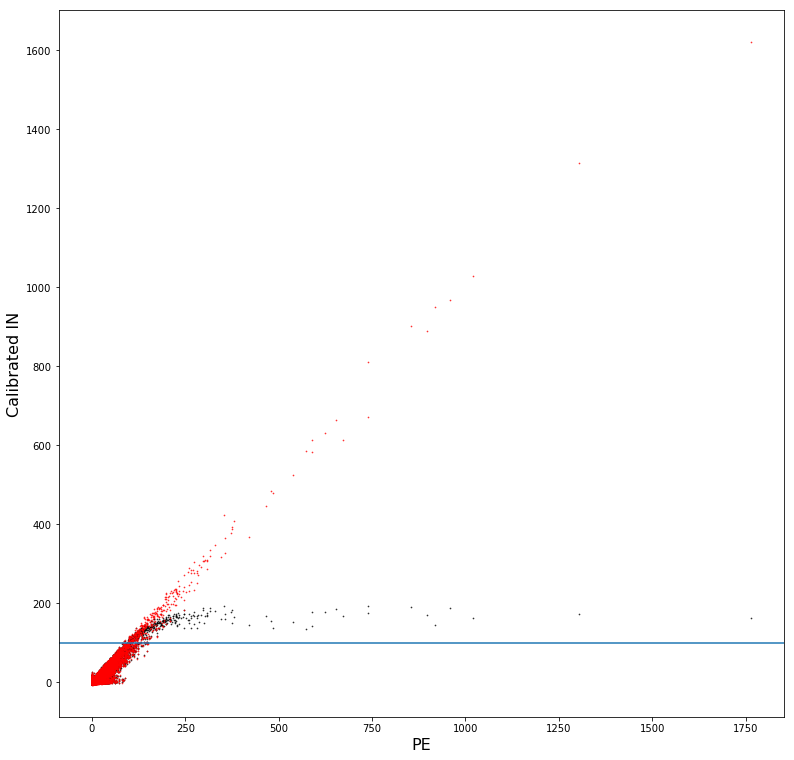

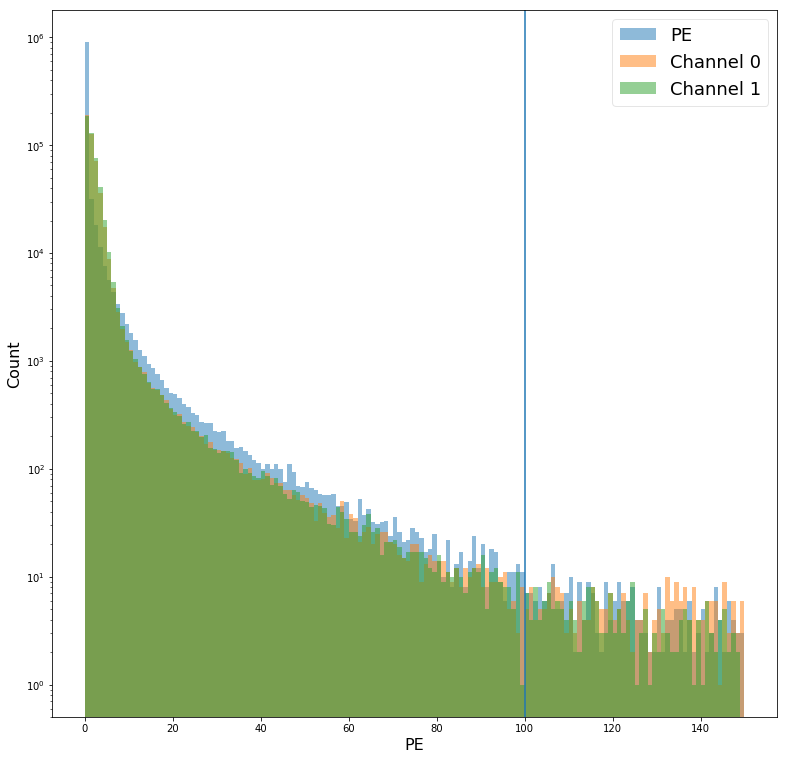

In [17]:
plot_all(grid_prod3b_north_proton_file_path,
         tel_id_filter_list=list(range(1, 9)),
         channel_threshold=lstcam_prod3_channel_threshold)

### FlashCam

FlashCam = "FlashCam" (tel 9 to 42 and 111 to 115 in prod3b - North site (LaPalma)), **1 channel**

### NectarCam

Nectarcam = "NectarCam" (tel 43 to 76 and 116 to 120 in prod3b - North site (LaPalma)), 2 channels

Tel ID range: [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 116, 117, 118, 119, 120]
Tel 43: NectarCam (hexagonal)
Tel 44: NectarCam (hexagonal)
Tel 45: NectarCam (hexagonal)
Tel 46: NectarCam (hexagonal)
Tel 47: NectarCam (hexagonal)
Tel 48: NectarCam (hexagonal)
Tel 49: NectarCam (hexagonal)
Tel 50: NectarCam (hexagonal)
Tel 51: NectarCam (hexagonal)
Tel 52: NectarCam (hexagonal)
Tel 53: NectarCam (hexagonal)
Tel 54: NectarCam (hexagonal)
Tel 55: NectarCam (hexagonal)
Tel 56: NectarCam (hexagonal)
Tel 57: NectarCam (hexagonal)
Tel 58: NectarCam (hexagonal)
Tel 59: NectarCam (hexagonal)
Tel 60: NectarCam (hexagonal)
Tel 61: NectarCam (hexagonal)
Tel 62: NectarCam (hexagonal)
Tel 63: NectarCam (hexagonal)
Tel 64: NectarCam (hexagonal)
Tel 65: NectarCam (hexagonal)
Tel 66: NectarCam (hexagonal)
Tel 67: NectarCam (hexagonal)
Tel 68: NectarCam (hexagonal)
Tel 69: NectarCam (hexagonal)
Tel 70: Nectar

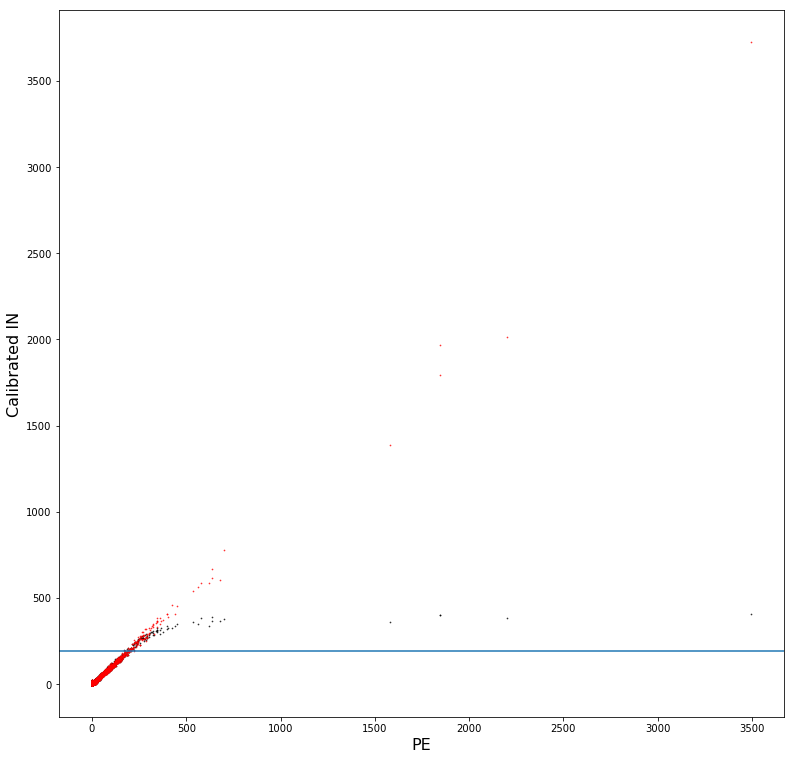

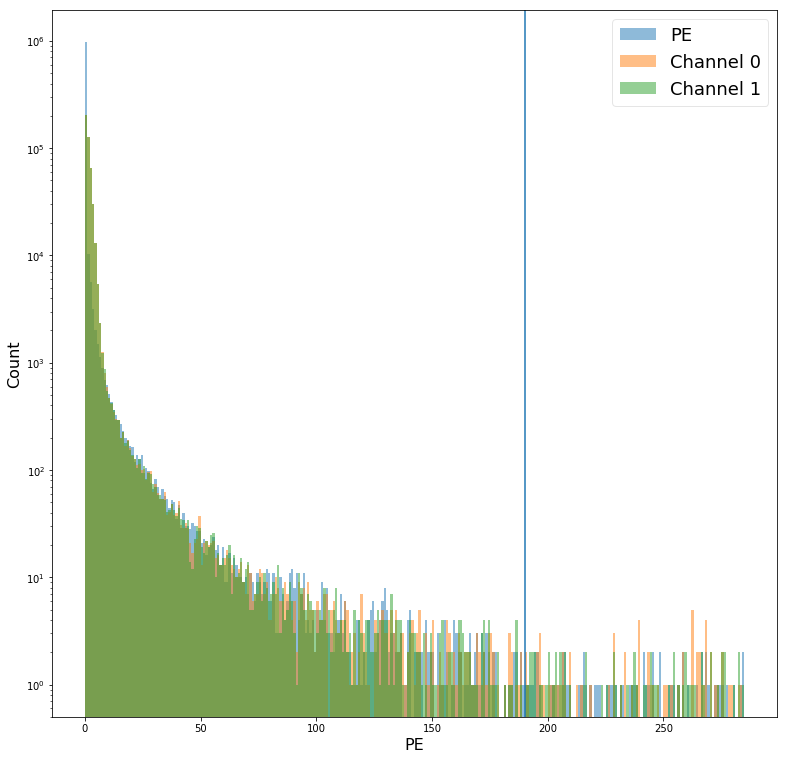

In [18]:
plot_all(grid_prod3b_north_gamma_file_path,
         tel_id_filter_list=list(range(43, 77)) + list(range(116, 121)),
         channel_threshold=nectarcam_prod3_channel_threshold)

Tel ID range: [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 116, 117, 118, 119, 120]
Tel 43: NectarCam (hexagonal)
Tel 44: NectarCam (hexagonal)
Tel 45: NectarCam (hexagonal)
Tel 46: NectarCam (hexagonal)
Tel 47: NectarCam (hexagonal)
Tel 48: NectarCam (hexagonal)
Tel 49: NectarCam (hexagonal)
Tel 50: NectarCam (hexagonal)
Tel 51: NectarCam (hexagonal)
Tel 52: NectarCam (hexagonal)
Tel 53: NectarCam (hexagonal)
Tel 54: NectarCam (hexagonal)
Tel 55: NectarCam (hexagonal)
Tel 56: NectarCam (hexagonal)
Tel 57: NectarCam (hexagonal)
Tel 58: NectarCam (hexagonal)
Tel 59: NectarCam (hexagonal)
Tel 60: NectarCam (hexagonal)
Tel 61: NectarCam (hexagonal)
Tel 62: NectarCam (hexagonal)
Tel 63: NectarCam (hexagonal)
Tel 64: NectarCam (hexagonal)
Tel 65: NectarCam (hexagonal)
Tel 66: NectarCam (hexagonal)
Tel 67: NectarCam (hexagonal)
Tel 68: NectarCam (hexagonal)
Tel 69: NectarCam (hexagonal)
Tel 70: Nectar

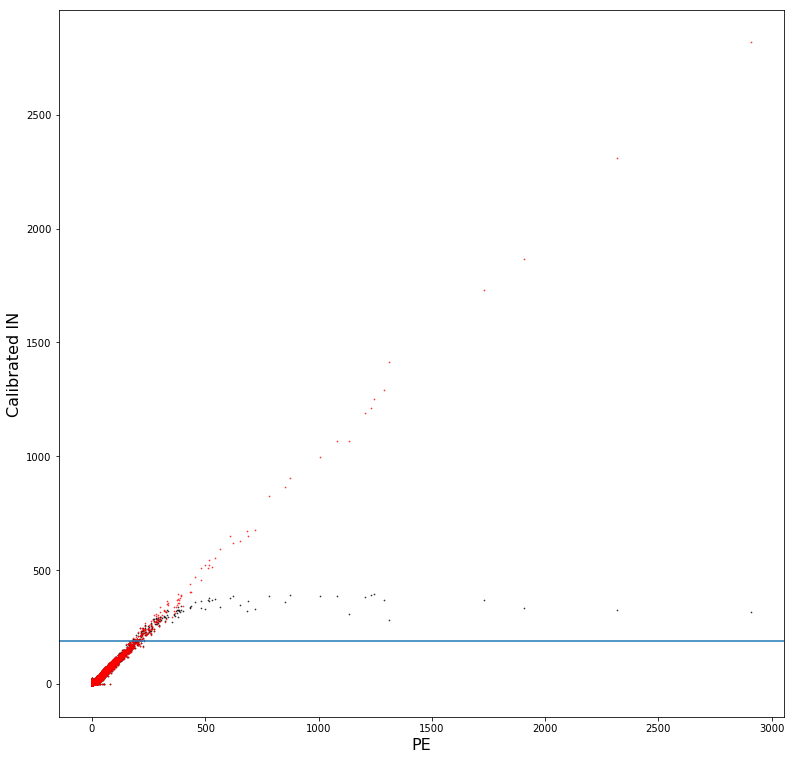

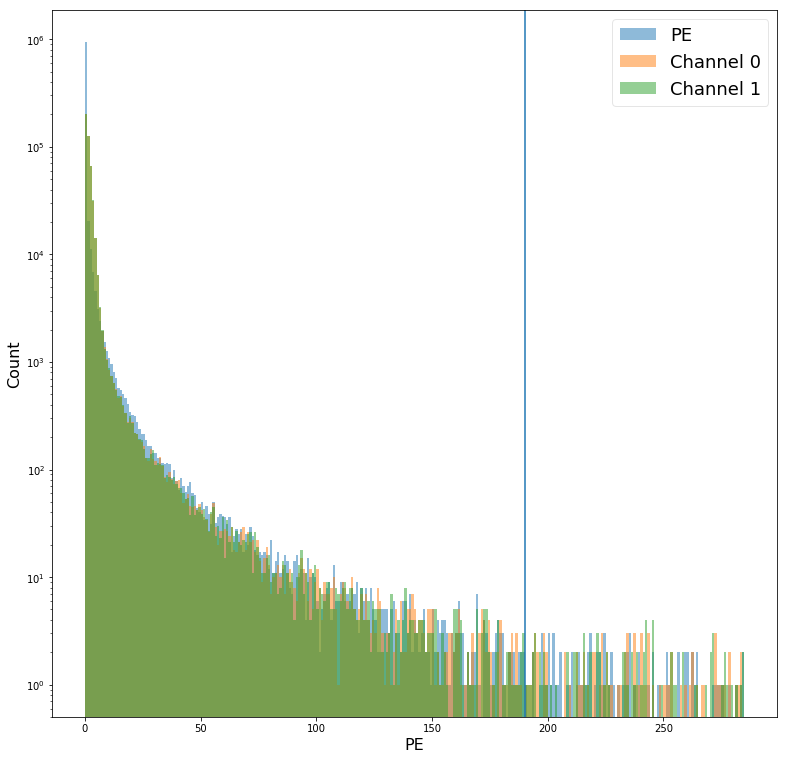

In [19]:
plot_all(grid_prod3b_north_proton_file_path,
         tel_id_filter_list=list(range(43, 77)) + list(range(116, 121)),
         channel_threshold=nectarcam_prod3_channel_threshold)

### SCTCam

SCTCam = "SCTCam" (tel 77 to 110 and 121 to 125 in prod3b - North site (LaPalma)), **1 channel**, MST

## Grid Prod3b - South site (Paranal)

In [9]:
grid_prod3b_south_gamma_file_path = "/Users/jdecock/data/grid_prod3b_south/simtel/gamma/gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz"
grid_prod3b_south_proton_file_path = "/Users/jdecock/data/grid_prod3b_south/simtel/proton/proton_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz"

In [1]:
%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/grid_prod3b_south/simtel/gamma/gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz

Telescope 001: LSTCam (hexagonal pixels)
Telescope 002: LSTCam (hexagonal pixels)
Telescope 003: LSTCam (hexagonal pixels)
Telescope 004: LSTCam (hexagonal pixels)
Telescope 005: LSTCam (hexagonal pixels)
Telescope 006: LSTCam (hexagonal pixels)
Telescope 007: LSTCam (hexagonal pixels)
Telescope 008: LSTCam (hexagonal pixels)
Telescope 009: LSTCam (hexagonal pixels)
Telescope 010: LSTCam (hexagonal pixels)
Telescope 011: LSTCam (hexagonal pixels)
Telescope 012: FlashCam (hexagonal pixels)
Telescope 013: FlashCam (hexagonal pixels)
Telescope 014: FlashCam (hexagonal pixels)
Telescope 015: FlashCam (hexagonal pixels)
Telescope 016: FlashCam (hexagonal pixels)
Telescope 017: FlashCam (hexagonal pixels)
Telescope 018: FlashCam (hexagonal pixels)
Telescope 019: FlashCam (hexagonal pixels)
Telescope 020: FlashCam (hexagonal pixels)
Telescope 021: FlashCam (hexagonal pixels)
Telescope 022: FlashCam (hexagonal pixels)
Telescope 023: FlashCam (hexagonal pixels)
Telescope 024: FlashCam (hexagona

In [ ]:
#%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/grid_prod3b_south/simtel/proton/proton_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz

### LSTCam

Dragoncam = "LSTCam" (tel 1 to 11 in prod3b - South site (Paranal)), 2 channels

Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Tel 1: LSTCam (hexagonal)
Tel 2: LSTCam (hexagonal)
Tel 3: LSTCam (hexagonal)
Tel 4: LSTCam (hexagonal)
Tel 5: LSTCam (hexagonal)
Tel 6: LSTCam (hexagonal)
Tel 7: LSTCam (hexagonal)
Tel 8: LSTCam (hexagonal)
Tel 9: LSTCam (hexagonal)
Tel 10: LSTCam (hexagonal)
Tel 11: LSTCam (hexagonal)
ch0 max: 190.096587744
num samples: 1001700


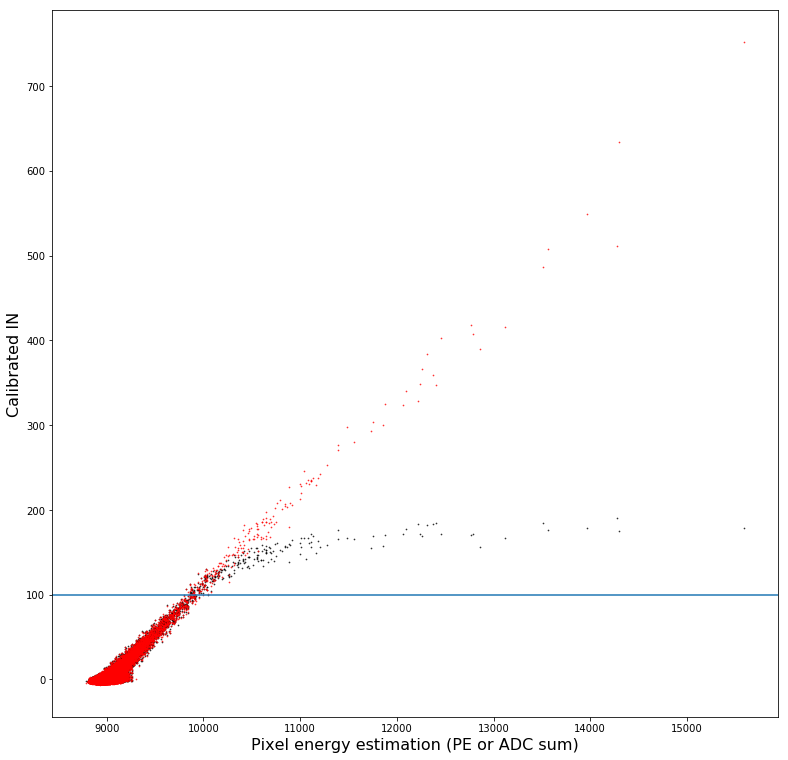

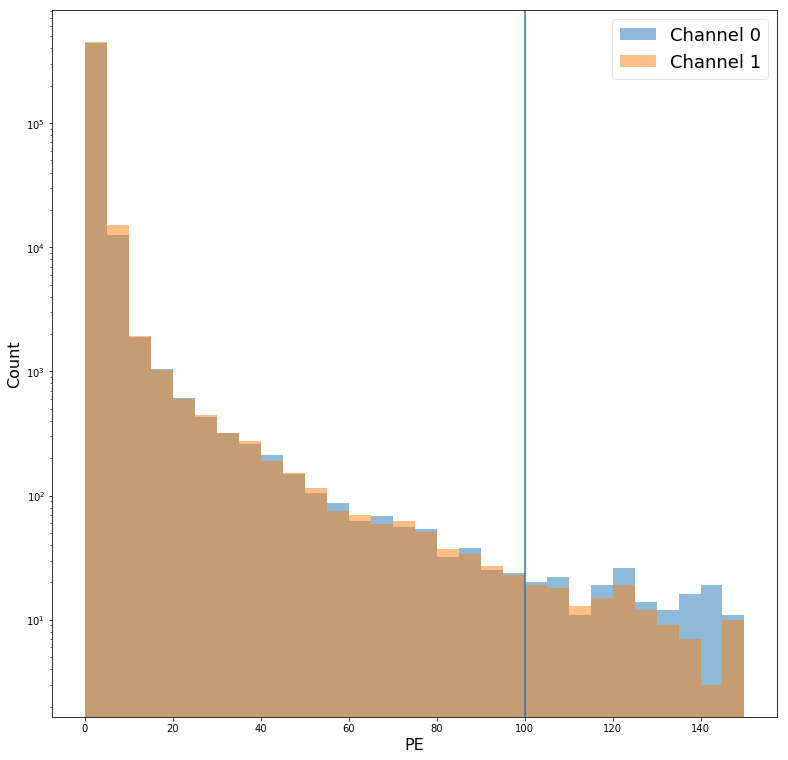

In [28]:
plot_all(grid_prod3b_south_gamma_file_path,
         tel_id_filter_list=list(range(1, 12)),
         channel_threshold=lstcam_prod3_channel_threshold)

Tel ID range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Tel 1: LSTCam (hexagonal)
Tel 2: LSTCam (hexagonal)
Tel 3: LSTCam (hexagonal)
Tel 4: LSTCam (hexagonal)
Tel 5: LSTCam (hexagonal)
Tel 6: LSTCam (hexagonal)
Tel 7: LSTCam (hexagonal)
Tel 8: LSTCam (hexagonal)
Tel 9: LSTCam (hexagonal)
Tel 10: LSTCam (hexagonal)
Tel 11: LSTCam (hexagonal)
ch0 max: 199.737276558
num samples: 1001700


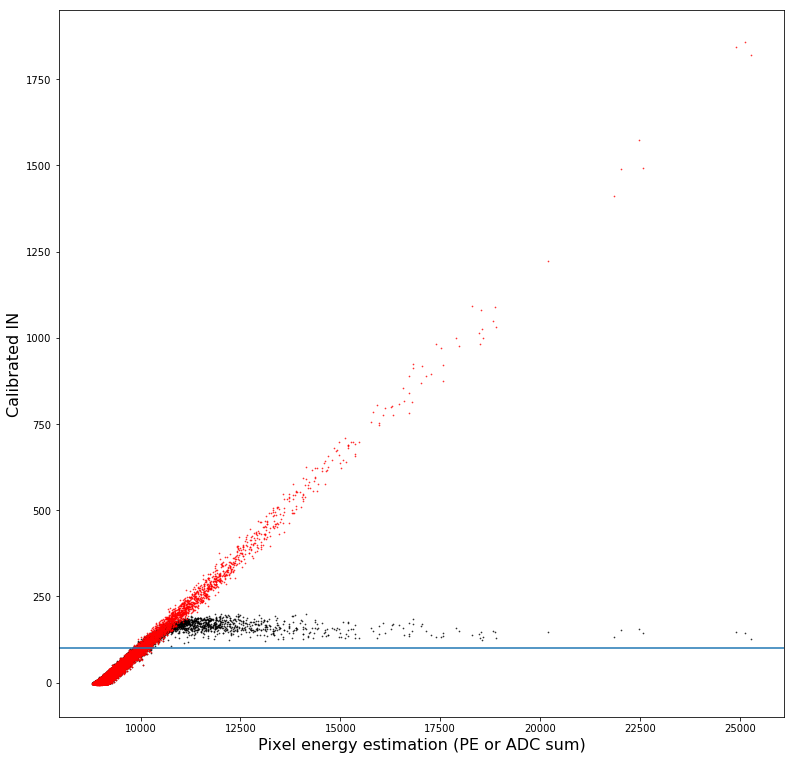

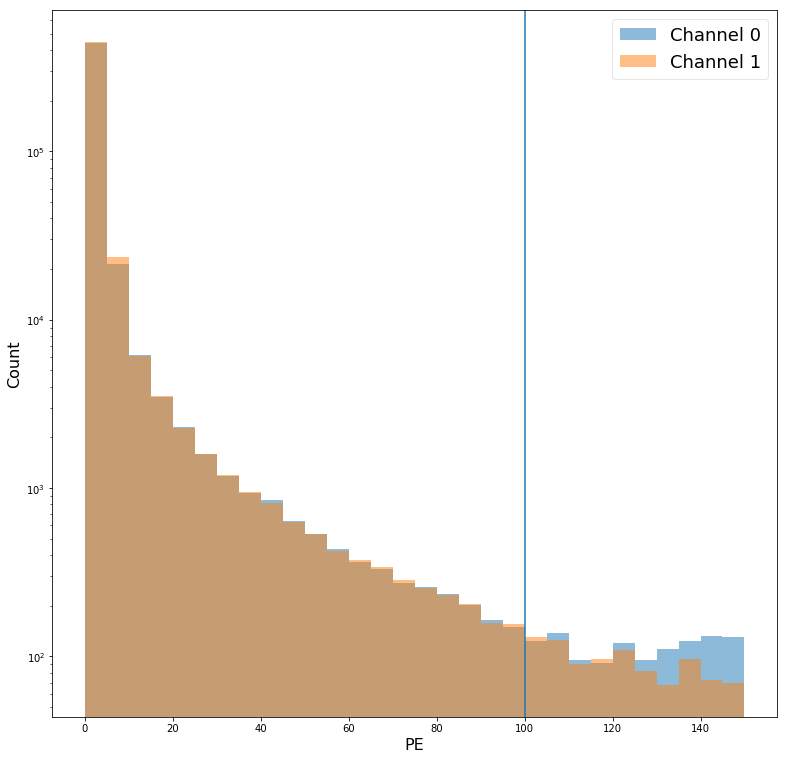

In [29]:
plot_all(grid_prod3b_south_proton_file_path,
         tel_id_filter_list=list(range(1, 12)),
         channel_threshold=lstcam_prod3_channel_threshold)

### FlashCam

FlashCam = "FlashCam" (tel 12 to 52 in prod3b - South site (Paranal)), **1 channel**

### NectarCam

Nectarcam = "NectarCam" (tel 53 to 93 in prod3b - South site (Paranal)), 2 channels

Tel ID range: [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
Tel 53: NectarCam (hexagonal)
Tel 54: NectarCam (hexagonal)
Tel 55: NectarCam (hexagonal)
Tel 56: NectarCam (hexagonal)
Tel 57: NectarCam (hexagonal)
Tel 58: NectarCam (hexagonal)
Tel 59: NectarCam (hexagonal)
Tel 60: NectarCam (hexagonal)
Tel 61: NectarCam (hexagonal)
Tel 62: NectarCam (hexagonal)
Tel 63: NectarCam (hexagonal)
Tel 64: NectarCam (hexagonal)
Tel 65: NectarCam (hexagonal)
Tel 66: NectarCam (hexagonal)
Tel 67: NectarCam (hexagonal)
Tel 68: NectarCam (hexagonal)
Tel 69: NectarCam (hexagonal)
Tel 70: NectarCam (hexagonal)
Tel 71: NectarCam (hexagonal)
Tel 72: NectarCam (hexagonal)
Tel 73: NectarCam (hexagonal)
Tel 74: NectarCam (hexagonal)
Tel 75: NectarCam (hexagonal)
Tel 76: NectarCam (hexagonal)
Tel 77: NectarCam (hexagonal)
Tel 78: NectarCam (hexagonal)
Tel 79: NectarCam (hexagonal)
Tel 80: Nec

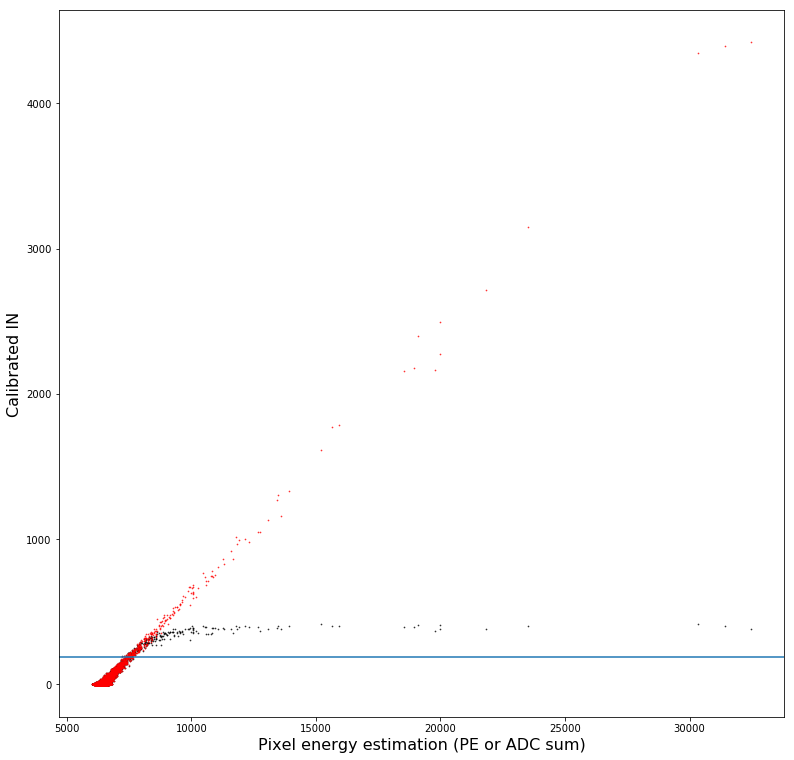

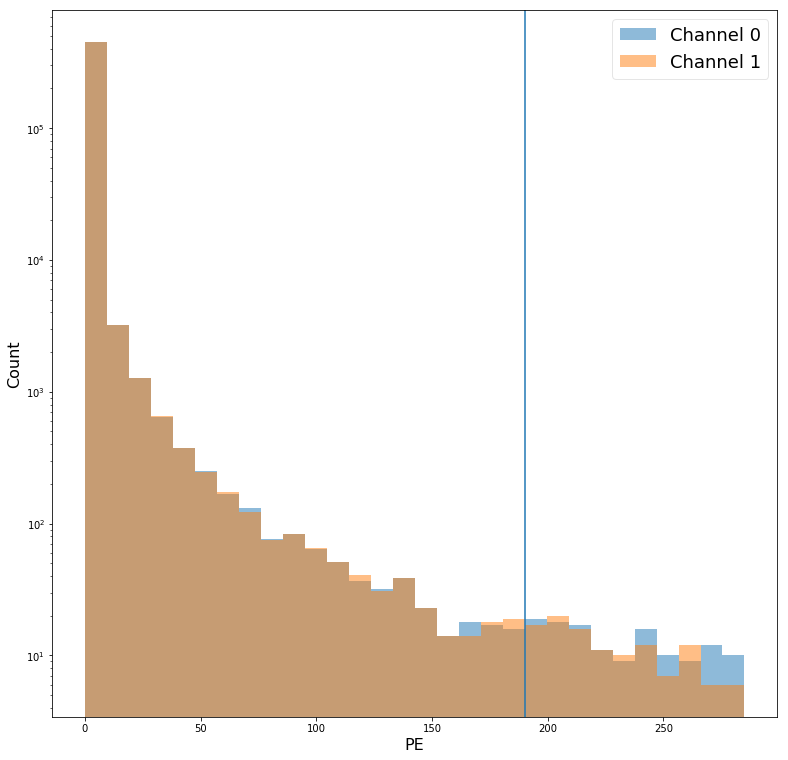

In [ ]:
plot_all(grid_prod3b_south_gamma_file_path,
         tel_id_filter_list=list(range(53, 94)),
         channel_threshold=nectarcam_prod3_channel_threshold)

In [ ]:
plot_all(grid_prod3b_south_proton_file_path,
         tel_id_filter_list=list(range(53, 94)),
         channel_threshold=nectarcam_prod3_channel_threshold)

Tel ID range: [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]


### ASTRI

ASTRI = "ASTRICam" (tel 94 to 251 in prod3b - South site (Paranal)), 2 channel

Tel ID range: [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
Tel 94: ASTRICam (rectangular)
Tel 95: ASTRICam (rectangular)
Tel 96: ASTRICam (rectangular)
Tel 97: ASTRICam (rectangular)
Tel 98: ASTRICam (rectangular)
Tel 99: ASTRICam (rectangular)
Tel 100: ASTRIC

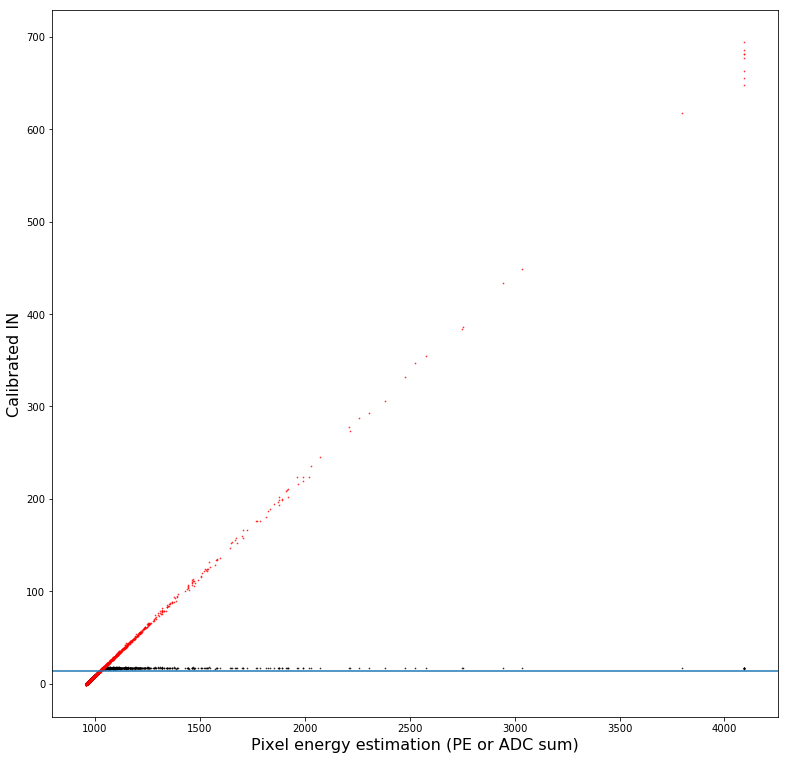

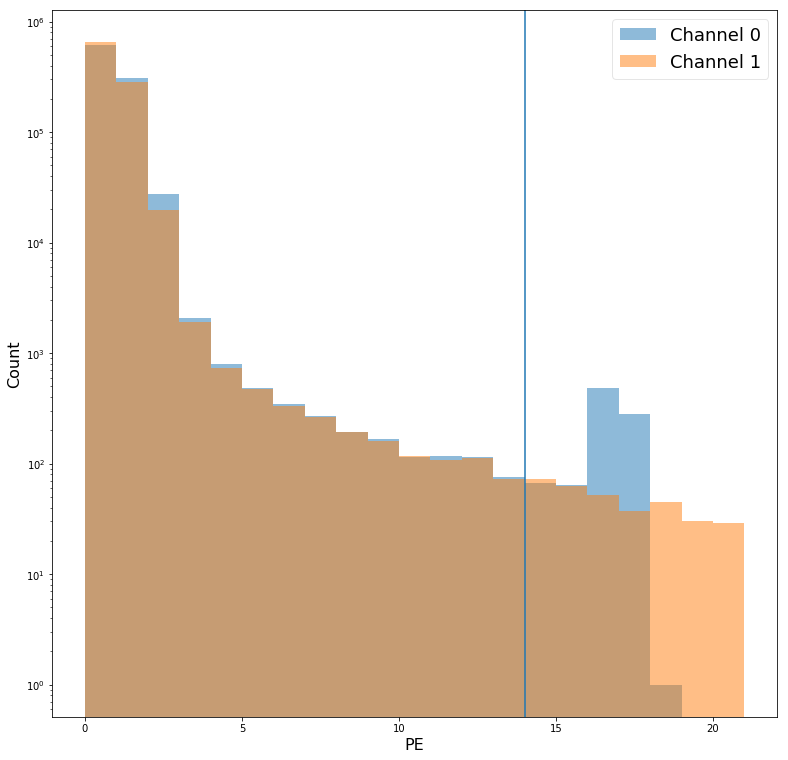

In [22]:
plot_all(grid_prod3b_south_gamma_file_path,
         tel_id_filter_list=list(range(94, 252)),
         channel_threshold=astri_channel_threshold)

Tel ID range: [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
Tel 94: ASTRICam (rectangular)
Tel 95: ASTRICam (rectangular)
Tel 96: ASTRICam (rectangular)
Tel 97: ASTRICam (rectangular)
Tel 98: ASTRICam (rectangular)
Tel 99: ASTRICam (rectangular)
Tel 100: ASTRIC

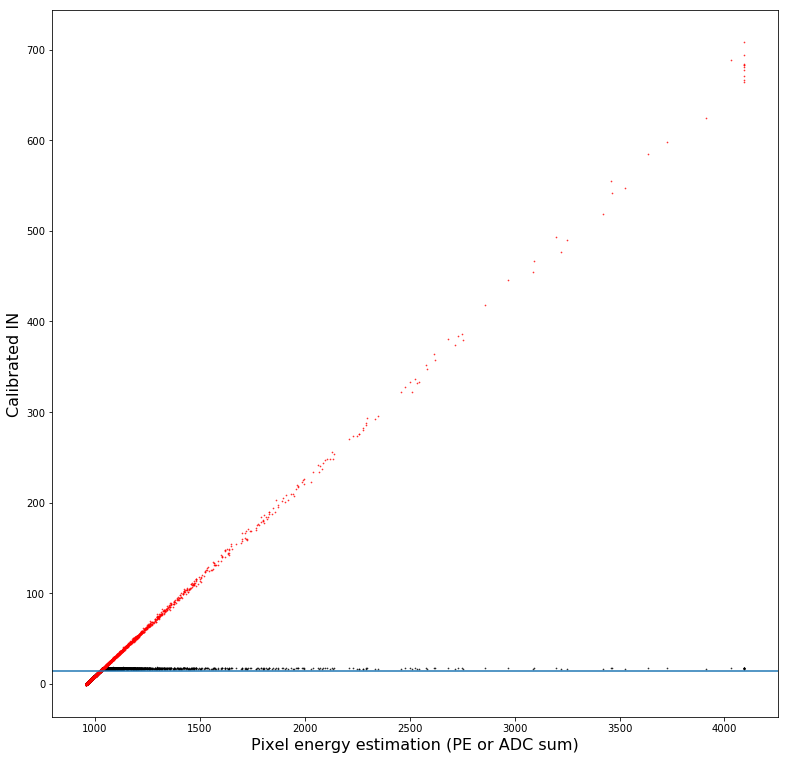

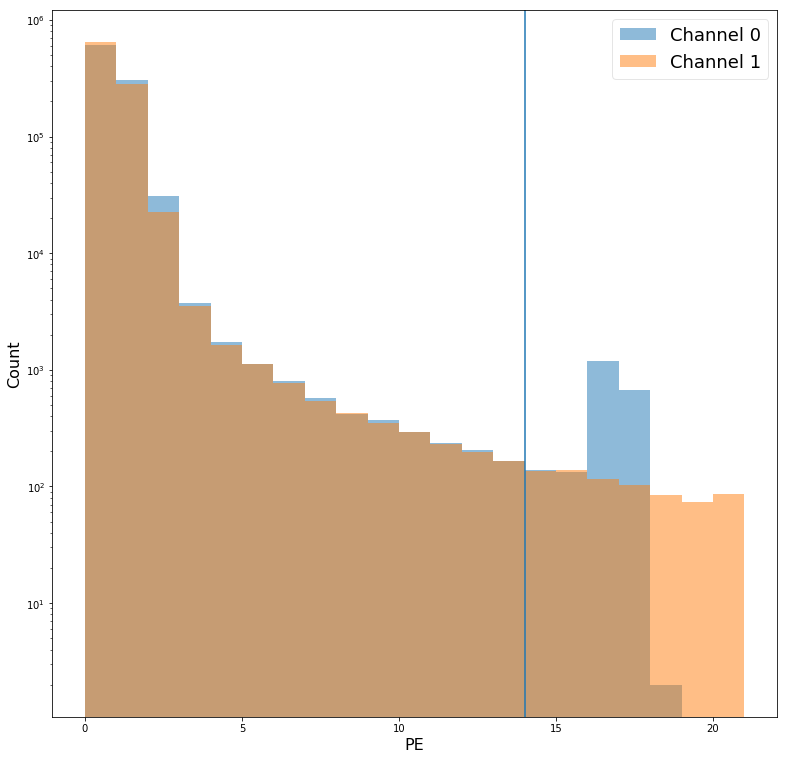

In [21]:
plot_all(grid_prod3b_south_proton_file_path,
         tel_id_filter_list=list(range(94, 252)),
         channel_threshold=astri_channel_threshold)

### GCT

GCT = "CHEC" (tel 252 to 409 in prod3b - South site (Paranal)), **1 channel**

### DigiCam

SSTm1 = "DigiCam" (tel 410 to 567 in prod3b (Grid production) - **South site (Paranal)**), 1 channel

## Channel mix snippet

In [20]:
img = np.array([[  1,   2,   3,   4, 5, 6, 6, 6, 6],
                [1.5, 2.5, 3.5, 4.5, 5, 6, 7, 8, 9]])

threshold = 5

img[1, img[0,:] <= threshold] = 0
img[0, img[0,:] >  threshold] = 0

#img[0, img[0,:] >  threshold] = 0
#img[1, img[1,:] <= threshold] = 0

print(img)

img = img.sum(axis=0)

print(img)

[[ 1.  2.  3.  4.  5.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  6.  7.  8.  9.]]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.]
